In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from tqdm import tqdm
import scanpy as sc
import SEACells

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
%matplotlib inline

Metacell identification was submitted as a job.

# Load metacell results

In [5]:
meta_ass = ad.read_h5ad('/home/e860a/chernova/my_onek1k_data/metacell_first_try/onek1k.metacell_assignment.h5ad')

In [43]:
meta = ad.read_h5ad('/home/e860a/chernova/my_onek1k_data/metacell_number_optim_230419/onek1k_CD4NC.metacells.30.h5ad')

In [47]:
meta_ass.obs.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,pool,individual,percent.mt,latent,nCount_SCT,nFeature_SCT,old_cell_type,old_cell_label,sex,age,pheno_id,ct_L0,ct_L1,ct_L2,ct_full,SEACell
index,,,,,,,,,,,,,,,,,,,
AAACCTGTCCTGCAGG-1,0,2623.0,667,0,682_683,2.859321,0,2798.0,667,0,CD4 NC,1,73,0__682_683,T,CD4T,CD4 Naive,CD4+ KLRB1- T cell,SEACell-0
AAACCTGTCGTACCGG-1,0,2946.0,777,0,682_683,2.410048,0,2902.0,777,0,CD4 NC,1,73,0__682_683,T,CD4T,CD4 Naive,CD4+ KLRB1- T cell,SEACell-0


In [63]:
meta.obs.head()

,pheno_ID
SEACell-0_0__682_683,0__682_683
SEACell-16_0__682_683,0__682_683
SEACell-15_0__682_683,0__682_683
SEACell-5_0__682_683,0__682_683
SEACell-6_0__682_683,0__682_683


# Load eQTL data

In [14]:
eqtl = pd.read_csv('/home/e860a/chernova/my_onek1k_data/eQTLs_patients.csv')

In [61]:
eqtl.head(3)

,Unnamed: 0,Cell type,Gene ID,Gene Ensembl ID,SNP,Chromosome,Position,SNP assessed allele,eSNP rank,rho correlation coefficient,S-statistics,pvalue,qvalue,FDR,ref_samples,hom_ref_samples,het_samples,hom_alt_samples
0,0,B IN,RP11-298J20.3,ENSG00000226899,rs4962711,10,126644482,C,eSNP1,-0.473,2.324188e+08,8.650000e-56,5.110000e-50,0.000022,0,"12_12,15_15,40_40,69_69,84_84,89_89,91_91,103_...","8_8,23_23,24_24,27_27,28_28,30_30,32_32,33_33,...","1_1,2_2,3_3,4_4,6_6,7_7,9_9,10_10,11_11,13_13,..."
1,1,B IN,PPA1,ENSG00000180817,rs12355080,10,71963608,A,eSNP1,0.428,9.033813e+07,6.310000e-45,1.650000e-40,0.000022,0,"1_1,4_4,7_7,8_8,10_10,15_15,17_17,18_18,21_21,...","3_3,6_6,11_11,12_12,13_13,16_16,19_19,20_20,23...","2_2,9_9,14_14,25_25,34_34,36_36,47_47,57_57,68..."
2,2,B IN,GDI2,ENSG00000057608,rs3736461,10,5855403,C,eSNP1,-0.278,2.017159e+08,6.760000e-19,6.080000e-15,0.000022,0,"1_1,3_3,4_4,7_7,8_8,9_9,12_12,13_13,14_14,18_1...","2_2,10_10,11_11,15_15,16_16,17_17,21_21,28_28,...","6_6,27_27,36_36,45_45,61_61,78_78,242_243,263_..."


# Plotting functions

In [50]:
def plot_violin(meta, eqtl, snp_array, rows, columns, savefig=None):
    
    colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']
    fig, ax = plt.subplots(rows, columns)
    fig.set_size_inches(3*columns, 3*rows)
    
    for i, snp in enumerate(snp_array):
        gene = eqtl.loc[snp, 'Gene Ensembl ID']
        gene_name = eqtl.loc[snp, 'Gene ID']
        u_snp = eqtl.loc[snp, 'SNP']
        expr_list = []
        class_list = []
        for col in range(3):
            column_list = []
            search_str = eqtl.loc[snp, colnames[col]]
            if type(search_str)==str:
                search_str = search_str.replace(',', '|') # Transform to regex

                #gene = eqtl.loc[snp, 'Gene Ensembl ID']
                cell_type = eqtl.loc[snp, 'Cell type']

                mask = meta.obs.pheno_ID.str.contains(search_str)

                x = meta[mask, gene].to_df().to_numpy().flatten()
            else:
                x = np.array([np.nan])
            if x.shape[0]==0:
                x = np.array([np.nan])
            expr_list.append(x)
            class_list.extend([colnames[col] for i in range(x.shape[0])])

        df= pd.DataFrame({'Expression':  np.concatenate(expr_list), 'Type': class_list})
        axis = ax.flatten()[i]
        sns.violinplot(df, x='Type', y='Expression',
                      ax = axis)
        # sns.stripplot(df, x='Type', y='Expression',
        #               # hue='Type',
        #               legend = False,
        #               color='grey',
        #               size=1.5,
        #               ax = axis)
        axis.set_xticklabels(['hom_ref','het', 'hom_alt'])
        axis.set_title(f'{gene_name},{u_snp}')             

    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig, dpi=300)

In [8]:
def cdf(x, label, ax, plot=True, *args, **kwargs):
    x, y = np.sort(x), np.arange(x.shape[0])/x.shape[0]
    if plot:
        # return sn.lineplot(pd.DataFrame({'Expression':x, 'Percentage':y}),
        #                    x='Percentage', y='Expression', *args, **kwargs)
        ax.plot(x, y, ':', label=label, *args, **kwargs)
    else:
        return x, y    

In [11]:
def plot_cdf(meta, eqtl, snp_array, rows, columns, delete_zeros=False, savefig=None):
    
    colnames = ['hom_ref_samples', 'het_samples', 'hom_alt_samples']
    fig, ax = plt.subplots(rows, columns)
    fig.set_size_inches(3*columns, 3*rows)
    
    for i, snp in enumerate(snp_array):
        gene = eqtl.loc[snp, 'Gene Ensembl ID']
        gene_name = eqtl.loc[snp, 'Gene ID']
        u_snp = eqtl.loc[snp, 'SNP']
        expr_list = []
        for col in range(3):
            column_list = []
            search_str = eqtl.loc[snp, colnames[col]]
            if type(search_str)==str:
                search_str = search_str.replace(',', '|') # Transform to regex

                #gene = eqtl.loc[snp, 'Gene Ensembl ID']
                cell_type = eqtl.loc[snp, 'Cell type']
                mask = meta.obs.pheno_ID.str.contains(search_str)
                
                x = meta[mask, gene].to_df().to_numpy().flatten()
            else:
                x = np.array([np.nan])
            if x.shape[0]==0:
                x = np.array([np.nan])
            expr_list.append(x)
    
        axis = ax.flatten()[i]
        for sample in range(3):
            if delete_zeros:
                expr = expr_list[sample]
                cdf(expr[expr!=0], colnames[sample], ax=axis)
            else:
                cdf(expr_list[sample], colnames[sample], ax=axis)
        axis.legend()
        axis.set_title(f'{gene_name}, {u_snp}')        

    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig, dpi=300)

Plotting eQTLs with top q-value. Each point is a metacell.

In [54]:
eqtl_sorted = eqtl.sort_values('qvalue')
cd4_mask = eqtl_sorted['Cell type']=='CD4 NC'

n_tops = 15
rows = 5
columns = 3

snp_array = eqtl_sorted.index.values[cd4_mask][:n_tops]
plot_violin(meta, eqtl, snp_array, rows, columns, savefig='figures_metacells/CD4NC_metacells_all_violinplot_30.png')

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

In [47]:
meta.obs['pheno_ID'] = meta.obs['pheno_id']

In [48]:
eqtl_sorted = eqtl.sort_values('qvalue')
cd4_mask = eqtl_sorted['Cell type']=='CD4 NC'

n_tops = 15
rows = 5
columns = 3

snp_array = eqtl_sorted.index.values[cd4_mask][:n_tops]
plot_cdf(meta, eqtl, snp_array, rows, columns)#, savefig='figures_metacells/CD4NC_metacells_all_cdf.png')

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

# Load TF data

In [31]:
tf_df = pd.read_csv('/home/e860a/chernova/my_onek1k_data/TF_list.csv')

In [32]:
tf_df = tf_df[tf_df['Is TF?']=='Yes']

In [33]:
# TFs where an SNP was found
tf_ids = np.intersect1d(eqtl['Gene Ensembl ID'], tf_df['Ensembl ID'])
tf_ids.shape

(386,)

In [32]:
np.unique(tf_ids).shape

(386,)

# Plotting eQTLs acting on TFs

In [34]:
# Just select eQTLs acting on TFs
search_str = '|'.join(tf_ids)
tf_eqtl = eqtl[eqtl['Gene Ensembl ID'].str.contains(search_str, regex=True)]

In [35]:
tf_eqtl_sorted = tf_eqtl.sort_values('qvalue')

In [40]:
cd4_mask = tf_eqtl_sorted['Cell type']=='CD4 NC'

n_tops = 15
rows = 5
columns = 3

snp_array = tf_eqtl_sorted.index.values[cd4_mask][:n_tops]
plot_violin(meta, eqtl, snp_array, rows, columns, savefig='figures_metacells/CD4NC_metacells_tf_violinplot_nostripplot.png')

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

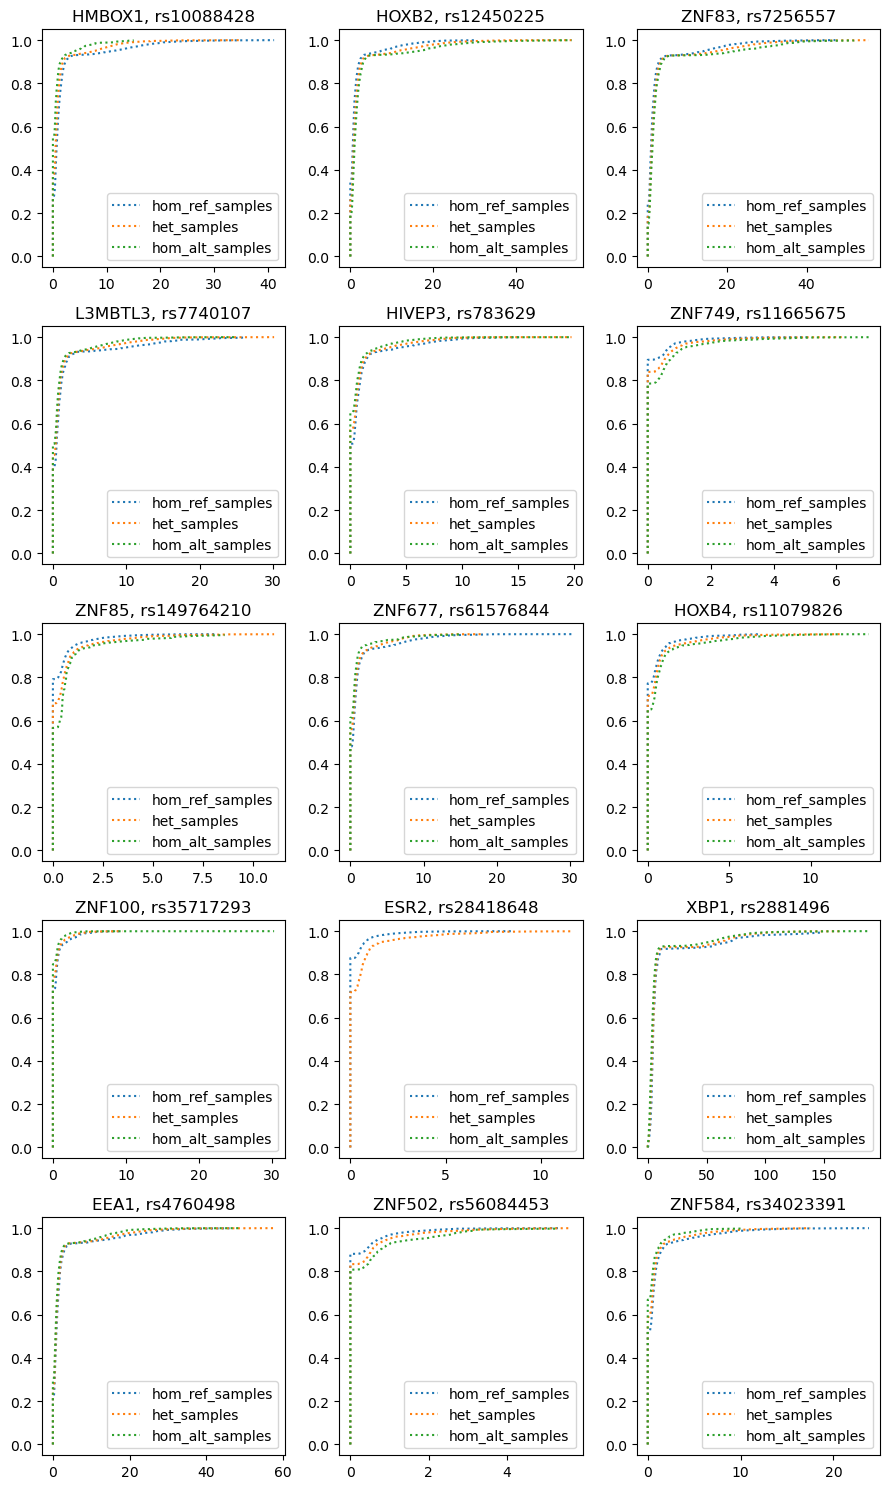

In [125]:
cd4_mask = tf_eqtl_sorted['Cell type']=='CD4 NC'

n_tops = 15
rows = 5
columns = 3

snp_array = tf_eqtl_sorted.index.values[cd4_mask][:n_tops]
plot_cdf(meta, eqtl, snp_array, rows, columns)

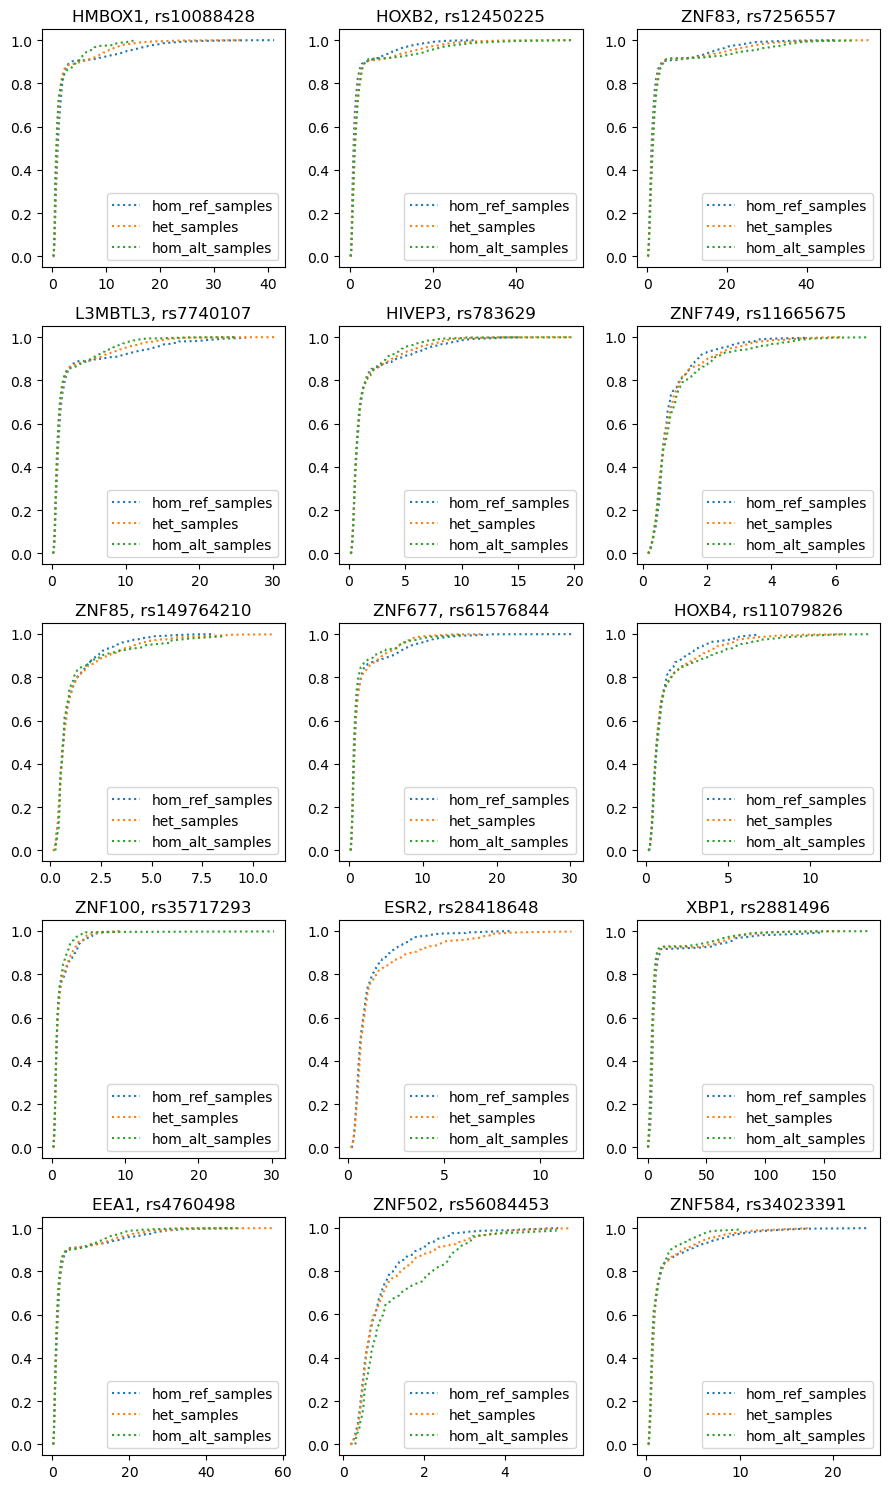

In [129]:
cd4_mask = tf_eqtl_sorted['Cell type']=='CD4 NC'

n_tops = 15
rows = 5
columns = 3

snp_array = tf_eqtl_sorted.index.values[cd4_mask][:n_tops]
plot_cdf(meta, eqtl, snp_array, rows, columns, delete_zeros=True)

# Analyse quality of the metacell clustering

In [132]:
meta_ass.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,pool,individual,percent.mt,latent,nCount_SCT,nFeature_SCT,old_cell_type,old_cell_label,sex,age,pheno_id,ct_L0,ct_L1,ct_L2,ct_full,SEACell
index,,,,,,,,,,,,,,,,,,,
AAACCTGTCCTGCAGG-1,0,2623.0,667,0,682_683,2.859321,0,2798.0,667,0,CD4 NC,1,73,0__682_683,T,CD4T,CD4 Naive,CD4+ KLRB1- T cell,SEACell-0
AAACCTGTCGTACCGG-1,0,2946.0,777,0,682_683,2.410048,0,2902.0,777,0,CD4 NC,1,73,0__682_683,T,CD4T,CD4 Naive,CD4+ KLRB1- T cell,SEACell-0
AAACGGGAGTAGATGT-1,0,3777.0,1008,0,682_683,3.097697,0,3091.0,1008,0,CD4 NC,1,73,0__682_683,T,CD4T,CD4 TCM,CD4+ KLRB1- T cell,SEACell-0
AAACGGGGTAGCCTAT-1,0,2891.0,897,0,682_683,2.663438,0,2889.0,897,0,CD4 NC,1,73,0__682_683,T,CD4T,CD4 TCM,CD4+ KLRB1- T cell,SEACell-0
AAACGGGGTATAAACG-1,0,4069.0,906,0,682_683,1.376260,0,3118.0,905,0,CD4 NC,1,73,0__682_683,T,CD4T,CD4 Naive,CD4+ KLRB1- T cell,SEACell-16


In [229]:
compactness = []
metacells = []
for patient in tqdm(np.unique(meta_ass.obs.pheno_id)):
    patient_mask = meta_ass.obs.pheno_id == patient
    for seacell in np.unique(meta_ass[patient_mask].obs.SEACell):
        seacell_mask = meta_ass.obs.SEACell == seacell
        selected = sparse.csr_matrix.todense(meta_ass.X[np.logical_and(patient_mask, seacell_mask)])
        compactness.append(np.mean(np.std(selected, axis=0)))
        metacells.append('_'.join([seacell, patient]))
compactness_df = pd.DataFrame({'metacell':metacells, 'compactness':compactness})

100%|██████████| 612/612 [01:12<00:00,  8.46it/s]


In [215]:
compactness_df.head()

,metacell,compactness
0,SEACell-0_0__682_683,0.055458
1,SEACell-1_0__682_683,0.034904
2,SEACell-10_0__682_683,0.030957
3,SEACell-11_0__682_683,0.033654
4,SEACell-12_0__682_683,0.033942


In [158]:
meta.obs.head()

,pheno_ID
SEACell-0_0__682_683,0__682_683
SEACell-16_0__682_683,0__682_683
SEACell-15_0__682_683,0__682_683
SEACell-5_0__682_683,0__682_683
SEACell-6_0__682_683,0__682_683


In [245]:
separation = []
metacells = []
for patient in tqdm(np.unique(meta.obs.pheno_ID)):
    patient_mask = meta.obs.pheno_ID == patient
    for seacell in np.unique(meta[patient_mask].obs.index.values):
        # Not distance to itself
        mask = np.logical_and(patient_mask, meta.obs.index.values!=seacell)
        #substract = meta[patient_mask].to_df().apply(lambda row: row - meta[seacell, :].to_df(), axis=0)
        matrix_to_subst = np.tile(sparse.csr_matrix.todense(meta[seacell, :].X),
                                  (meta[mask].X.shape[0], 1))
        min_dist = np.min(np.mean(np.abs(meta[mask].X - matrix_to_subst), axis=1))
        separation.append(min_dist)
        metacells.append(seacell)
separation_df = pd.DataFrame({'metacell':metacells, 'separation':separation})

100%|██████████| 612/612 [01:05<00:00,  9.41it/s]


In [198]:
separation_df.head()

,metacell,separation
0,SEACell-0_0__682_683,0.055458
1,SEACell-10_0__682_683,0.034904
2,SEACell-11_0__682_683,0.030957
3,SEACell-12_0__682_683,0.033654
4,SEACell-13_0__682_683,0.033942


In [246]:
metrics_df = compactness_df.merge(separation_df, on='metacell', how='outer')

In [210]:
metrics_df.head()

,metacell,compactness,separation
0,SEACell-0_0__682_683,0.055458,0.055458
1,SEACell-1_0__682_683,0.034904,0.036814
2,SEACell-10_0__682_683,0.030957,0.034904
3,SEACell-11_0__682_683,0.033654,0.030957
4,SEACell-12_0__682_683,0.033942,0.033654


<Axes: xlabel='separation', ylabel='compactness'>

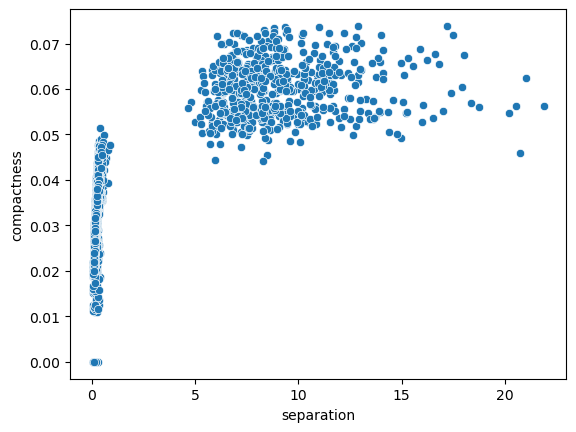

In [247]:
sns.scatterplot(metrics_df, x='separation', y='compactness')

# Analyse of different metacell sizes

Datasets with different number of cells pro metacell.

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

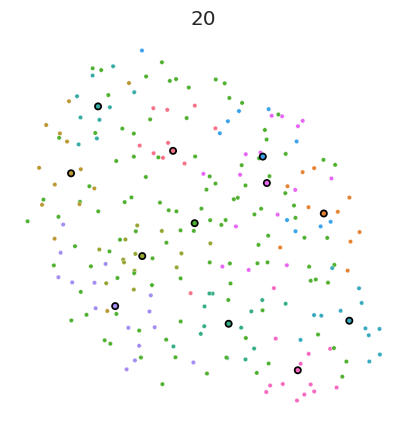

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

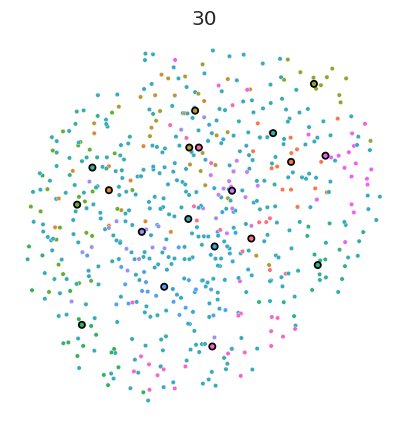

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

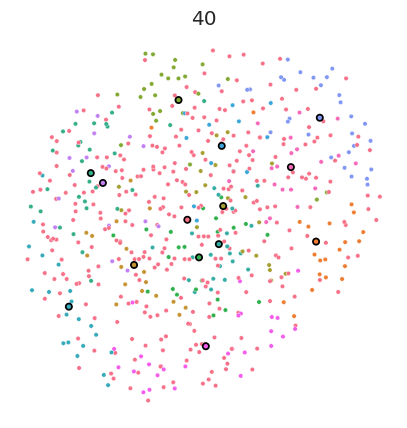

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

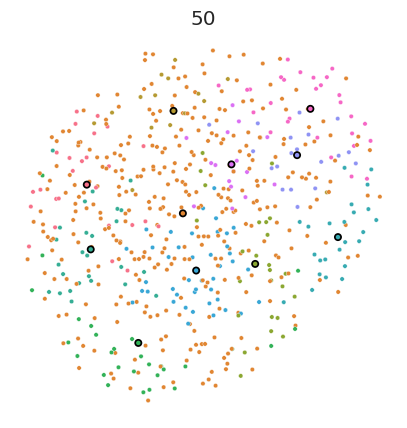

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

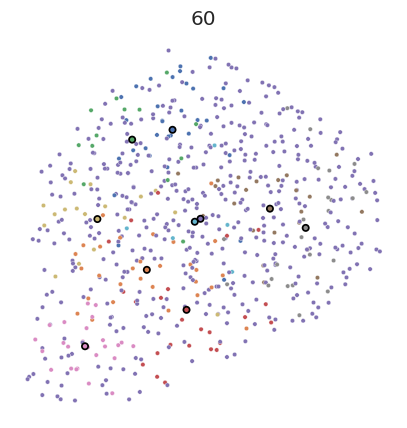

findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: 

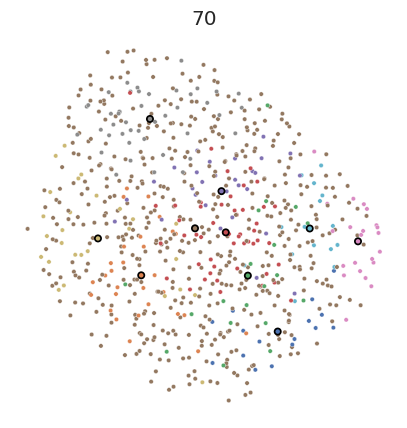

In [ ]:
for i in range(20, 91, 10):
    ann_data = ad.read_h5ad(f'/home/e860a/chernova/my_onek1k_data/metacell_number_optim/onek1k_CD4NC.metacell_assignment.{i}.h5ad')
    ann_data = ann_data[ann_data.obs.individual==np.unique(ann_data.obs.individual)[0]]
    # ann_data.obs['SEACell_old'] = ann_data.obs['SEACell']
    # ann_data.obs['SEACell'] = ann_data.obs['SEACell'].str.cat(ann_data.obs['individual'])
    sc.pp.neighbors(ann_data)
    sc.tl.umap(ann_data)
    SEACells.plot.plot_2D(ann_data, key='X_umap', title = i)


Comparing metrics for different metacell sizes.

In [8]:
def separation(meta_adata):
    
    separation = []
    metacells = []
    
    for patient in np.unique(meta_adata.obs.pheno_id):
        patient_mask = meta_adata.obs.pheno_id == patient
        
        for seacell in np.unique(meta_adata[patient_mask].obs.index.values):

            # Not distance to itself
            mask = np.logical_and(patient_mask, meta_adata.obs.index.values!=seacell)

            matrix_to_subst = np.tile(sparse.csr_matrix.todense(meta_adata[seacell, :].X),
                                    (meta_adata[mask].X.shape[0], 1))
            min_dist = np.min(np.mean(np.abs(meta_adata[mask].X - matrix_to_subst), axis=1))
            separation.append(min_dist)
            metacells.append(seacell)
            
    separation_df = pd.DataFrame({'metacell':metacells, 'separation':separation})
    
    return separation_df

def compactness(meta_assignments):
    
    compactness = []
    metacells = []
    
    for patient in np.unique(meta_assignments.obs.pheno_id):
        patient_mask = meta_assignments.obs.pheno_id == patient
        
        for seacell in np.unique(meta_assignments[patient_mask].obs.SEACell):
            seacell_mask = meta_assignments.obs.SEACell == seacell
            selected = sparse.csr_matrix.todense(meta_assignments.X[np.logical_and(patient_mask, seacell_mask)])
            compactness.append(np.mean(np.std(selected, axis=0)))
            metacells.append('_'.join([seacell, patient]))
            
    compactness_df = pd.DataFrame({'metacell':metacells, 'compactness':compactness})
    
    return compactness_df

def metrics(meta, meta_assignments):
    comp_df = compactness(meta_assignments)
    sep_df = separation(meta)
    return comp_df.merge(sep_df, on='metacell', how='outer')

100%|██████████| 8/8 [02:15<00:00, 16.99s/it]
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font family 'Bitstream Vera Sans' not found.
findfont: Font fami

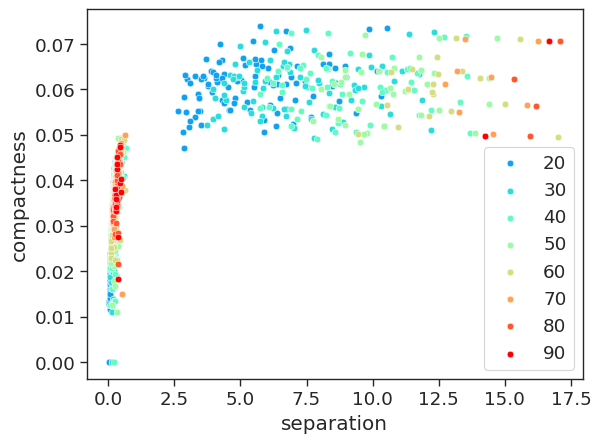

In [9]:
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
for i in tqdm(range(20, 91, 10)):
    ann_data = ad.read_h5ad(f'/home/e860a/chernova/my_onek1k_data/metacell_number_optim_230419/onek1k_CD4NC.metacell_assignment.{i}.h5ad')
    meta = ad.read_h5ad(f'/home/e860a/chernova/my_onek1k_data/metacell_number_optim_230419/onek1k_CD4NC.metacells.{i}.h5ad')
    metrics_list = []
    for patient in np.unique(ann_data.obs.pheno_id):
        mask_meta = meta.obs.pheno_id==patient
        mask_ann_data = ann_data.obs.pheno_id==patient
        metrics_patient = metrics(meta[mask_meta], ann_data[mask_ann_data])
        metrics_list.append(metrics_patient)
    metrics_df = metrics_df = pd.concat(metrics_list, ignore_index=True)
    sns.scatterplot(metrics_df, x='separation', y='compactness', label = i, color=colors[i//10])